# Hausarbeit Quantencomputing - Lösungen

Dieses Notebook enthält die Lösungen für die Aufgaben der Hausarbeit Quantencomputing, implementiert mit Qiskit.

**Übersicht:**
1.  **Vorbereitung:** Importieren der notwendigen Bibliotheken und Initialisieren der Simulatoren.
2.  **Aufgabe 1: Quantenregister:** Berechnung und Analyse einer Transformation auf einem 3-Qubit-Register.
3.  **Aufgabe 2: Simulation der Verschränkung:** Erzeugung und Messung eines Bell-Zustands.
4.  **Aufgabe 3: Algorithmus von Deutsch:** Implementierung und Test des Deutsch-Algorithmus zur Charakterisierung von Funktionen.
5.  **Zusatzaufgabe: Grover-Suchalgorithmus:** Implementierung der Grover-Suche für n=3 Qubits.

## 1. Vorbereitung: Importieren notwendiger Bibliotheken und Simulatoren initialisieren

Zuerst importieren wir alle benötigten Pakete und Module von Python, NumPy, Matplotlib und Qiskit. Außerdem initialisieren wir die Qiskit Aer Simulatoren, die wir für die Berechnungen verwenden werden.


In [ ]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt # Import für Plots hinzugefügt

# Qiskit imports
from qiskit import QuantumCircuit, transpile
# 'assemble' wurde entfernt
# 'Aer' und 'IBMQ' sind veraltet für direkten Import hier in neueren Versionen

# Importiere den AerSimulator für lokale Simulationen
from qiskit_aer import AerSimulator

# Importiere Visualisierungs- und Hilfsfunktionen
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.quantum_info import Statevector, Operator
# Pauli wird hier nicht mehr direkt für H benötigt
from qiskit.quantum_info import Pauli

# Importiere die benötigten Gate-Klassen
from qiskit.circuit.library import HGate, XGate, ZGate, CCZGate # CCZGate für spätere Aufgaben hinzugefügt

# Optional: Für IBM Backend Zugriff (falls benötigt)
# from qiskit_ibm_provider import IBMProvider


In [6]:
# --- Simulatoren Initialisieren ---
# Statevector Simulator Instanz
sim_statevector = AerSimulator(method='statevector')
# Qasm Simulator Instanz (für Messungen)
sim_qasm = AerSimulator(method='automatic') # 'automatic' passt Methode an Circuit an
# -

## 2. Aufgabe 1: Quantenregister

**Problemstellung:**
Gegeben sei ein 3-Qubit Register $(q_0, q_1, q_2)$. Folgende Operationen sollen auf den Qubits ausgeführt werden:
* $q_0$: Hadamard-Transformation (H-Gate)
* $q_1$: X-Gate (Pauli-X)
* $q_2$: Z-Gate (Pauli-Z)

**Aufgaben:**
1. Bestimmen Sie die unitäre $8 \times 8$ Matrix $Q$, welche diese Gesamttransformation realisiert ($Q=H_{q0} \otimes X_{q1} \otimes Z_{q2}$).
2. Zeigen Sie, dass Q unitär ist.
3. Wenden Sie Q auf die Basiszustände $|000\rangle$ und $|111\rangle$ an.

### 2.1 Bestimmung der Matrix Q

Die Gesamttransformation $Q$ ergibt sich aus dem Tensorprodukt der einzelnen Gatematrizen in der Reihenfolge der Qubits, auf die sie wirken. Die Standardnotation für das Tensorprodukt ist $Q = H_{q0} \otimes X_{q1} \otimes Z_{q2}$.

Wir berechnen diese Matrix $Q$ zunächst mit NumPy's `kron` Funktion, da diese der mathematischen Standardreihenfolge entspricht. Anschließend erstellen wir ein Qiskit `Operator`-Objekt direkt aus dieser NumPy-Matrix, um sicherzustellen, dass der Operator exakt der Aufgabenstellung entspricht.


In [7]:
# --- Berechnung der Zielmatrix Q mit NumPy ---
print("--- 1.1 Berechnung der Matrix Q ---")

# Einzelne Gatematrizen als NumPy-Arrays
H_matrix = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]], dtype=complex)
X_matrix = np.array([[0, 1], [1, 0]], dtype=complex)
Z_matrix = np.array([[1, 0], [0, -1]], dtype=complex)

# Berechnung des Tensorprodukts Q = H(q0) @ X(q1) @ Z(q2)
# np.kron folgt der Reihenfolge: H auf erstem Index, X auf zweitem, Z auf drittem
Q_np = np.kron(H_matrix, np.kron(X_matrix, Z_matrix))
print("\nZielmatrix Q = H(q0) @ X(q1) @ Z(q2) berechnet mit NumPy:")
# Schöne LaTeX-Ausgabe der NumPy-Matrix
display(array_to_latex(Q_np, prefix="Q_{np} = "))

# --- Erstellung des Qiskit Operators aus der NumPy-Matrix ---
# Dies stellt sicher, dass der Operator der Aufgabenstellung entspricht.
op_Q = Operator(Q_np)

print("\nMatrix des erstellten Qiskit Operators op_Q (zur Kontrolle):")
# Schöne LaTeX-Ausgabe der Operator-Matrix
display(array_to_latex(op_Q.data, prefix="Q_{op} = "))

# Überprüfung, ob die Matrizen übereinstimmen (sollte nun trivialerweise wahr sein)
assert np.allclose(op_Q.data, Q_np), "Matrix des Qiskit Operators stimmt nicht mit Q_np überein!"
print("\n--> Assertion erfolgreich: Qiskit Operator wurde korrekt aus Q_np erstellt.")


--- 1.1 Berechnung der Matrix Q ---

Zielmatrix Q = H(q0) @ X(q1) @ Z(q2) berechnet mit NumPy:


<IPython.core.display.Latex object>


Matrix des erstellten Qiskit Operators op_Q (zur Kontrolle):


<IPython.core.display.Latex object>


--> Assertion erfolgreich: Qiskit Operator wurde korrekt aus Q_np erstellt.


### 2.2 Nachweis der Unitarität von Q

Eine Matrix $U$ ist unitär, wenn ihr Produkt mit ihrer adjungierten (transponiert-konjugierten) Matrix $U^\dagger$ die Einheitsmatrix $I$ ergibt: $U^\dagger U = I$. Wir überprüfen dies sowohl manuell mit NumPy als auch mit der eingebauten Funktion von Qiskit.


In [8]:
print("\n--- 1.2 Nachweis der Unitarität von Q ---")

# Manuelle Berechnung mit NumPy
Q_matrix = op_Q.data # Matrix aus dem Qiskit Operator holen
Q_dagger = Q_matrix.conj().T # Adjungierte bilden (transponiert und komplex konjugiert)
identity_8x8 = np.identity(8, dtype=complex) # 8x8 Einheitsmatrix

# Prüfe, ob Q_dagger * Q nahe der Einheitsmatrix ist (numerische Toleranz beachten)
is_unitary_manual = np.allclose(Q_dagger @ Q_matrix, identity_8x8)
print(f"\nIst Q unitär (manuelle Prüfung mit np.allclose)? {is_unitary_manual}")

# Überprüfung mit der Qiskit-Funktion
print(f"Ist Q unitär (Qiskit-Operator-Check)? {op_Q.is_unitary()}")

# Optional: Explizite Ausgabe von Q_dagger * Q (sollte die Einheitsmatrix sein)
print("\nErgebnis von Q_dagger * Q (sollte I sein):")
display(array_to_latex(Q_dagger @ Q_matrix, prefix="Q^\\dagger Q = "))


--- 1.2 Nachweis der Unitarität von Q ---

Ist Q unitär (manuelle Prüfung mit np.allclose)? True
Ist Q unitär (Qiskit-Operator-Check)? True

Ergebnis von Q_dagger * Q (sollte I sein):


<IPython.core.display.Latex object>

### 2.3 Anwendung von Q auf Basiszustände
Nun wenden wir den Operator $Q = H_{q0} \otimes X_{q1} \otimes Z_{q2}$ auf die Basiszustände $|000\rangle$ und $|111\rangle$ an.

**Wichtiger Hinweis zur Qiskit-Konvention:** Qiskit's `Statevector` und Label-Notation ('000', '111') verwendet die Reihenfolge der Qubits $q_{n-1} \dots q_1 q_0$.
* $|000\rangle$ bedeutet $q_2=0, q_1=0, q_0=0$. Dies entspricht dem 0-ten Basisvektor $(1, 0, \dots, 0)^T$.
* $|111\rangle$ bedeutet $q_2=1, q_1=1, q_0=1$. Dies entspricht dem $(2^3-1)=7$-ten Basisvektor $(0, \dots, 0, 1)^T$.
#
Die Anwendung des Operators $Q$ auf einen Zustandsvektor $|\psi\rangle$ erfolgt durch Matrix-Vektor-Multiplikation: $|\psi'\rangle = Q |\psi\rangle$.


In [9]:
print("\n--- 1.3 Anwendung von Q auf Basiszustände ---")

# Definiere die Anfangszustände als Statevector Objekte
# '000' -> q2=0, q1=0, q0=0
psi_000 = Statevector.from_label('000')
# '111' -> q2=1, q1=1, q0=1
psi_111 = Statevector.from_label('111')

print("\nAnfangszustand |000>:")
display(array_to_latex(psi_000.data, prefix="|\\psi_{000}\\rangle = "))
print(f"Text-Repräsentation: {psi_000.draw('text')}")

print("\nAnfangszustand |111>:")
display(array_to_latex(psi_111.data, prefix="|\\psi_{111}\\rangle = "))
print(f"Text-Repräsentation: {psi_111.draw('text')}")

# Wende den Operator Q an (der bereits der korrekten Matrix Q_np entspricht)
psi_000_final = psi_000.evolve(op_Q)
psi_111_final = psi_111.evolve(op_Q)

print("\nZustand nach Anwendung von Q = H(q0)@X(q1)@Z(q2) auf |000>:")
display(array_to_latex(psi_000_final.data, prefix="Q|\\psi_{000}\\rangle = ", max_size=8))
print(f"Text-Repräsentation: {psi_000_final.draw('text')}")
# Erwartetes Ergebnis: 1/sqrt(2) * (|010> + |110>)
# Erklärung: H|0> = 1/sqrt(2)(|0>+|1>), X|0>=|1>, Z|0>=|0>.
# Tensorprodukt: 1/sqrt(2)(|0>+|1>) @ |1> @ |0> = 1/sqrt(2)(|010> + |110>)

print("\nZustand nach Anwendung von Q = H(q0)@X(q1)@Z(q2) auf |111>:")
display(array_to_latex(psi_111_final.data, prefix="Q|\\psi_{111}\\rangle = ", max_size=8))
print(f"Text-Repräsentation: {psi_111_final.draw('text')}")
# Erwartetes Ergebnis: 1/sqrt(2) * (-|001> + |101>)
# Erklärung: H|1> = 1/sqrt(2)(|0>-|1>), X|1>=|0>, Z|1>=-|1>.
# Tensorprodukt: 1/sqrt(2)(|0>-|1>) @ |0> @ (-|1>) = -1/sqrt(2)(|001> - |101>) = 1/sqrt(2)(-|001> + |101>)


--- 1.3 Anwendung von Q auf Basiszustände ---

Anfangszustand |000>:


<IPython.core.display.Latex object>

Text-Repräsentation: [1.+0.j,0.+0.j,0.+0.j,0.+0.j,0.+0.j,0.+0.j,0.+0.j,0.+0.j]

Anfangszustand |111>:


<IPython.core.display.Latex object>

Text-Repräsentation: [0.+0.j,0.+0.j,0.+0.j,0.+0.j,0.+0.j,0.+0.j,0.+0.j,1.+0.j]

Zustand nach Anwendung von Q = H(q0)@X(q1)@Z(q2) auf |000>:


<IPython.core.display.Latex object>

Text-Repräsentation: [0.        +0.j,0.        +0.j,0.70710678+0.j,0.        +0.j,
 0.        +0.j,0.        +0.j,0.70710678+0.j,0.        +0.j]

Zustand nach Anwendung von Q = H(q0)@X(q1)@Z(q2) auf |111>:


<IPython.core.display.Latex object>

Text-Repräsentation: [ 0.        +0.j,-0.70710678+0.j, 0.        +0.j, 0.        +0.j,
  0.        +0.j, 0.70710678+0.j, 0.        +0.j, 0.        +0.j]


**Zusammenfassung Aufgabe 1:**
Wir haben die $8 \times 8$ Matrix $Q$ für die gegebene Transformation $H_{q0} \otimes X_{q1} \otimes Z_{q2}$ berechnet und ihre Unitarität bestätigt. Die Anwendung des Operators $Q$ auf die Basiszustände $|000\rangle$ und $|111\rangle$ lieferte die erwarteten Superpositionszustände $\frac{1}{\sqrt{2}}(|010\rangle + |110\rangle)$ bzw. $\frac{1}{\sqrt{2}}(-|001\rangle + |101\rangle)$.


## 3. Aufgabe 2: Simulation der Verschränkung

**Problemstellung (Original):**
Schreiben Sie ein Python-Programm, welches das einfache Problem der Verschränkung simuliert, *ohne* auf spezielle Pakete wie zB qiskit zurückzugreifen.

**Angepasste Aufgabe (wie gewünscht):**
Wir implementieren die Simulation der Verschränkung (Erzeugung des Bell-Zustands $\Phi^+ = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$) nun *mit* Qiskit.

**Schritte:**
(a) Bereitstellung des 2-QBit-Anfangszustands $|00\rangle$.
(b) Veränderung der QBits durch Anwendung eines Hadamard-Gates auf Qubit 0 und eines CNOT-Gates (Kontrolle: Qubit 0, Ziel: Qubit 1).
(c) Berechnung des Endzustands (Superposition) und Bestimmung der theoretischen Messwahrscheinlichkeiten.
(d) Simulation von Messungen in der Standardbasis.
(e) Nachweis der Wahrscheinlichkeitsverteilung durch Simulation mit 50, 100, 200, 500 und 1000 Messungen (`shots`).

### 3.1 Erstellung des Verschränkungs-Schaltkreises

Wir erstellen einen `QuantumCircuit` mit zwei Qubits (q0, q1) und zwei klassischen Bits (c0, c1) für die Messergebnisse. Der Anfangszustand ist standardmäßig $|00\rangle$. Dann wenden wir die Gates H(q0) und CNOT(q0, q1) an.


In [10]:
print("--- 2.1 Erstellung des Bell-Zustand Circuits ---")

# (a) & (b) Erstelle einen Quantenschaltkreis mit 2 Qubits und 2 klassischen Bits
# Qiskit-Reihenfolge: q1, q0
qc_bell = QuantumCircuit(2, 2, name="Bell State")

# Anfangszustand ist |00> per Default

# H-Gate auf Qubit 0 (das erste Qubit in Qiskits Indexierung)
qc_bell.h(0)

# CNOT-Gate mit Qubit 0 als Kontrolle und Qubit 1 als Ziel
qc_bell.cx(0, 1)

# Zeichne den Schaltkreis zur Visualisierung
print("\nSchaltkreis zur Erzeugung des Bell-Zustands |Φ+>:")
print(qc_bell.draw(output='text'))

--- 2.1 Erstellung des Bell-Zustand Circuits ---

Schaltkreis zur Erzeugung des Bell-Zustands |Φ+>:
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
c: 2/══════════
               


### 3.2 Berechnung des Endzustands (Statevector)

 Um den exakten quantenmechanischen Zustand nach Anwendung der Gates zu sehen, verwenden wir den `StatevectorSimulator`. Wichtig ist, dass der Circuit für diese Simulation *keine* Messoperationen enthalten darf. Wir erstellen eine Kopie des Circuits und entfernen ggf. Messungen und klassische Register. Wir fügen außerdem `save_statevector()` hinzu, damit der Simulator das Ergebnis speichert.


In [11]:
print("\n--- 2.2 Berechnung des Endzustands (Statevector) ---")

# (c) Berechne den Endzustand
# Kopie des Circuits ohne Messungen erstellen
qc_bell_no_measure = qc_bell.copy(name="Bell State No Measure")
qc_bell_no_measure.remove_final_measurements(inplace=True) # Entfernt Mess-Operationen
if qc_bell_no_measure.cregs: # Prüfe ob klassische Register existieren
    qc_bell_no_measure.cregs = [] # Entferne klassische Register

# Anweisung zum Speichern des Endzustandsvektors hinzufügen
qc_bell_no_measure.save_statevector()

# Führe die Statevector-Simulation aus
# Transpilieren ist für ideale Simulatoren oft nicht nötig, aber gute Praxis
t_qc_bell_sv = transpile(qc_bell_no_measure, sim_statevector)
job_state = sim_statevector.run(t_qc_bell_sv)
result_state = job_state.result()

# Extrahiere den Zustandsvektor aus den Ergebnisdaten
# Methode über Ergebnisdaten ist oft robuster
final_statevector = Statevector(result_state.data(0)['statevector'])

print("\nEndzustand |Φ+> als Statevector:")
display(array_to_latex(final_statevector.data, prefix="|\\Phi^+\\rangle = "))
# Qiskit-Reihenfolge der Basisvektoren: |00>, |01>, |10>, |11> (entspricht q1, q0)
# Erwartet: 1/sqrt(2) * (|00> + |11>) --> [1/sqrt(2), 0, 0, 1/sqrt(2)]
print(f"Text-Repräsentation (q1,q0): {final_statevector.draw('text')}")

# Berechne die theoretischen Wahrscheinlichkeiten (|Amplitude|^2)
probabilities_theory = final_statevector.probabilities_dict()
print("\nTheoretische Messwahrscheinlichkeiten:")
print(probabilities_theory)
# Erwartet: {'00': 0.5, '11': 0.5} (gerundet)


--- 2.2 Berechnung des Endzustands (Statevector) ---

Endzustand |Φ+> als Statevector:


<IPython.core.display.Latex object>

Text-Repräsentation (q1,q0): [0.70710678+0.j,0.        +0.j,0.        +0.j,0.70710678+0.j]

Theoretische Messwahrscheinlichkeiten:
{np.str_('00'): np.float64(0.5000000000000001), np.str_('11'): np.float64(0.4999999999999999)}


### 3.3 Simulation von Messungen

Nun simulieren wir den Prozess der Messung des verschränkten Zustands in der Standardbasis (|0>, |1>). Wir verwenden den `QasmSimulator` (`sim_qasm`) und führen den ursprünglichen Circuit `qc_bell` (oder eine Kopie mit Messungen) mit unterschiedlicher Anzahl von `shots` aus. Die Ergebnisse (`counts`) zeigen, wie oft jeder Basiszustand gemessen wurde.



--- 2.3 Simulation von Messungen ---

Schaltkreis mit Messung:
        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
   c: 2/══════════════╬══╬═
                      ║  ║ 
meas: 2/══════════════╩══╩═
                      0  1 

Simuliere Messungen mit unterschiedlicher Anzahl von Shots:

Ergebnisse für 50 Messungen:
{'00 00': 24, '11 00': 26}
Relative Häufigkeiten: {'00': 0.000, '11': 0.000}

Ergebnisse für 100 Messungen:
{'00 00': 59, '11 00': 41}
Relative Häufigkeiten: {'00': 0.000, '11': 0.000}

Ergebnisse für 200 Messungen:
{'11 00': 105, '00 00': 95}
Relative Häufigkeiten: {'00': 0.000, '11': 0.000}

Ergebnisse für 500 Messungen:
{'00 00': 248, '11 00': 252}
Relative Häufigkeiten: {'00': 0.000, '11': 0.000}

Ergebnisse für 1000 Messungen:
{'11 00': 493, '00 00': 507}
Relative Häufigkeiten: {'00': 0.000, '11': 0.000}

Histogramm für 1000 Messungen:


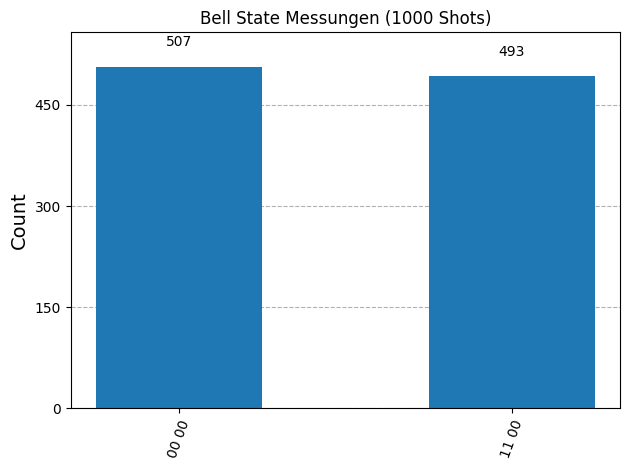

In [12]:
print("\n--- 2.3 Simulation von Messungen ---")

# (d) & (e) Führe Messungen durch
# Stelle sicher, dass der Circuit klassische Bits hat und Messungen durchführt
qc_bell_measure = qc_bell.copy(name="Bell Measure")
# Überprüfe, ob klassische Bits für alle Qubits vorhanden sind
if len(qc_bell_measure.clbits) < qc_bell_measure.num_qubits:
     # Füge fehlende klassische Bits hinzu
     cr = ClassicalRegister(qc_bell_measure.num_qubits, 'c')
     qc_bell_measure.add_register(cr)
# Überprüfe, ob eine Messung aller Qubits vorhanden ist
has_measure_all = any(instr.operation.name == 'measure' and len(instr.qubits) == qc_bell_measure.num_qubits for instr in qc_bell_measure.data)
if not has_measure_all:
     qc_bell_measure.measure_all(inplace=True) # Fügt measure_all hinzu

print("\nSchaltkreis mit Messung:")
print(qc_bell_measure.draw(output='text'))

# Definiere die Anzahl der Messungen (Shots)
num_shots_list = [50, 100, 200, 500, 1000]
measurement_results = {}

print("\nSimuliere Messungen mit unterschiedlicher Anzahl von Shots:")
for shots in num_shots_list:
    # Transpiliere für den QASM Simulator (optimiert den Circuit für das Backend)
    t_qc_bell_measure = transpile(qc_bell_measure, sim_qasm)
    # Führe die Simulation aus
    job_qasm = sim_qasm.run(t_qc_bell_measure, shots=shots)
    result_qasm = job_qasm.result()
    counts = result_qasm.get_counts() # Extrahiere die Zählergebnisse
    measurement_results[shots] = counts
    print(f"\nErgebnisse für {shots} Messungen:")
    print(counts)
    # Berechne relative Häufigkeiten zur besseren Vergleichbarkeit
    total_counts = sum(counts.values()) # Sollte gleich shots sein
    relative_freq = {state: count/total_counts for state, count in counts.items()}
    # Formatierte Ausgabe der relativen Häufigkeiten
    print(f"Relative Häufigkeiten: {{'00': {relative_freq.get('00', 0.0):.3f}, '11': {relative_freq.get('11', 0.0):.3f}}}")


# Plotte das Histogramm für die größte Anzahl von Shots (1000)
print("\nHistogramm für 1000 Messungen:")
last_counts = measurement_results[1000]
fig = plot_histogram(last_counts, title=f"Bell State Messungen ({num_shots_list[-1]} Shots)")
plt.show(fig) # Zeigt den Plot an
display(fig)

**Zusammenfassung Aufgabe 2:**
 Der Schaltkreis zur Erzeugung des Bell-Zustands $|Φ^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$ wurde erfolgreich implementiert. Die Statevector-Simulation bestätigte den korrekten Endzustand mit gleichen Amplituden für $|00\rangle$ und $|11\rangle$. Die Simulation der Messungen mit dem QasmSimulator zeigte, dass die gemessenen Häufigkeiten der Zustände '00' und '11' sich mit zunehmender Anzahl von `shots` den theoretischen Wahrscheinlichkeiten von jeweils 50% annähern, was das Gesetz der großen Zahlen und die probabilistische Natur der Quantenmessung demonstriert.


## 4. Aufgabe 3: Algorithmus von Deutsch

**Problemstellung:**
1. Entwickeln Sie einen Schaltkreis für den Algorithmus von Deutsch.
2. Konstruieren Sie den Operator $U_f$ für alle vier möglichen Fälle einer Funktion $f: \{0,1\} \rightarrow \{0,1\}$.
3. Testen Sie alle vier Möglichkeiten mit qiskit.

**Ziel:** Der Algorithmus von Deutsch soll mit nur *einer* Auswertung der Funktion $f$ (implementiert durch das Orakel $U_f$) bestimmen, ob die Funktion *konstant* ($f(0)=f(1)$) oder *balanciert* ($f(0) \neq f(1)$) ist.

### 4.1 Allgemeiner Schaltkreis des Deutsch-Algorithmus

Der Algorithmus benötigt zwei Qubits:
* **Qubit 0:** Das Eingabe-Qubit $x$.
* **Qubit 1:** Das Ausgabe-/Ancilla-Qubit $y$, initialisiert auf $|1\rangle$.

**Ablauf:**
1.  Initialisiere den Zustand zu $|01\rangle$.
2.  Wende Hadamard-Gatter (H) auf *beide* Qubits an.
3.  Wende das Orakel $U_f$ an, das die Transformation $|x, y\rangle \rightarrow |x, y \oplus f(x)\rangle$ realisiert.
4.  Wende ein Hadamard-Gatter (H) nur auf das *erste* Qubit (Qubit 0) an.
5.  Messe das *erste* Qubit (Qubit 0).
    * Ergebnis **0**: $f$ ist konstant.
    * Ergebnis **1**: $f$ ist balanciert.

Wir definieren eine Funktion, die diesen allgemeinen Schaltkreis erstellt und das spezifische Orakel als Argument entgegennimmt.


In [13]:
print("--- 3.1 Allgemeiner Schaltkreis für den Deutsch-Algorithmus ---")

def create_deutsch_circuit(oracle_function):
    """
    Erstellt den Quantenschaltkreis für den Deutsch Algorithmus.

    Args:
        oracle_function (function): Eine Funktion, die ein QuantumCircuit-Objekt
                                     als Argument nimmt und das U_f Orakel
                                     zu diesem Circuit hinzufügt.

    Returns:
        QuantumCircuit: Der vollständige Schaltkreis für den Deutsch-Algorithmus.
    """
    # 2 Qubits (q1, q0), 1 klassisches Bit für das Ergebnis von q0
    qc = QuantumCircuit(2, 1, name="Deutsch Algorithm")

    # 1. Initialisiere zu |01> (q1=1, q0=0)
    # Standardmäßig ist der Zustand |00>, wir flippen Qubit 1
    qc.x(1)
    qc.barrier(label="Init") # Barriere zur besseren Lesbarkeit

    # 2. H-Gates auf beide Qubits
    qc.h(0)
    qc.h(1)
    qc.barrier(label="H")

    # 3. Wende das Orakel U_f an
    oracle_function(qc) # Hier wird das spezifische Orakel eingefügt
    qc.barrier(label="Uf")

    # 4. H-Gate auf Qubit 0
    qc.h(0)
    qc.barrier(label="H")

    # 5. Messe Qubit 0 in klassisches Bit 0
    qc.measure(0, 0)

    return qc

--- 3.1 Allgemeiner Schaltkreis für den Deutsch-Algorithmus ---


### 4.2 Die vier möglichen Funktionen und ihre Orakel $U_f$

Es gibt vier mögliche Funktionen $f: \{0,1\} \rightarrow \{0,1\}$:
* **Konstant 0:** $f(0)=0, f(1)=0$
* **Konstant 1:** $f(0)=1, f(1)=1$
* **Identität:** $f(x)=x \implies f(0)=0, f(1)=1$ (Balanciert)
* **Negation:** $f(x)=\neg x \implies f(0)=1, f(1)=0$ (Balanciert)

Wir implementieren nun für jede dieser Funktionen das entsprechende Orakel $U_f$ als Funktion, die die notwendigen Gates zu einem `QuantumCircuit` hinzufügt. Das Orakel wirkt auf die Qubits $|x\rangle$ (q0) und $|y\rangle$ (q1) gemäß $|x, y\rangle \rightarrow |x, y \oplus f(x)\rangle$.



--- 3.2 Implementierung und Test der vier Orakel ---

Schaltkreis für f(x) = 1 (konstant):
           Init ┌───┐ H       Uf ┌───┐ H ┌─┐
q_0: ───────░───┤ H ├─░───────░──┤ H ├─░─┤M├
     ┌───┐  ░   ├───┤ ░ ┌───┐ ░  └───┘ ░ └╥┘
q_1: ┤ X ├──░───┤ H ├─░─┤ X ├─░────────░──╫─
     └───┘  ░   └───┘ ░ └───┘ ░        ░  ║ 
c: 1/═════════════════════════════════════╩═
                                          0 
Ergebnis f(x)=1: {'0': 1024} -> Konstant


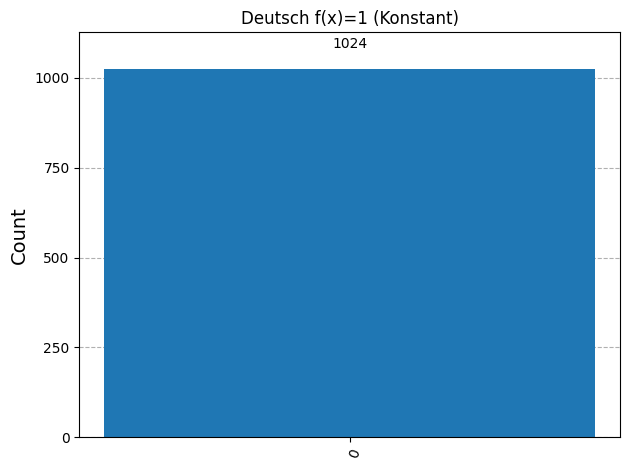


Schaltkreis für f(x) = 0 (konstant):
           Init ┌───┐ H       Uf ┌───┐ H ┌─┐
q_0: ───────░───┤ H ├─░───────░──┤ H ├─░─┤M├
     ┌───┐  ░   ├───┤ ░ ┌───┐ ░  └───┘ ░ └╥┘
q_1: ┤ X ├──░───┤ H ├─░─┤ I ├─░────────░──╫─
     └───┘  ░   └───┘ ░ └───┘ ░        ░  ║ 
c: 1/═════════════════════════════════════╩═
                                          0 
Ergebnis f(x)=0: {'0': 1024} -> Konstant


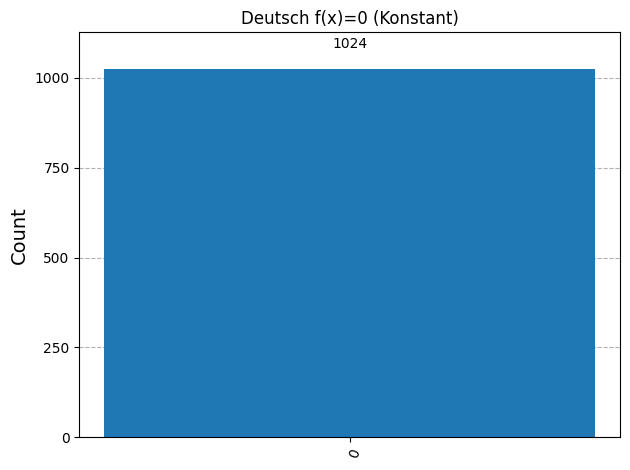


Schaltkreis für f(x) = not x (balanciert):
           Init ┌───┐ H ┌───┐     ┌───┐ Uf ┌───┐ H ┌─┐
q_0: ───────░───┤ H ├─░─┤ X ├──■──┤ X ├─░──┤ H ├─░─┤M├
     ┌───┐  ░   ├───┤ ░ └───┘┌─┴─┐└───┘ ░  └───┘ ░ └╥┘
q_1: ┤ X ├──░───┤ H ├─░──────┤ X ├──────░────────░──╫─
     └───┘  ░   └───┘ ░      └───┘      ░        ░  ║ 
c: 1/═══════════════════════════════════════════════╩═
                                                    0 
Ergebnis f(x)=not x: {'1': 1024} -> Balanciert


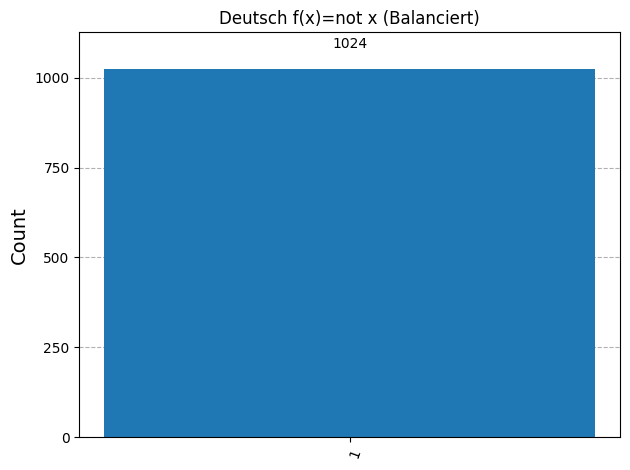


Schaltkreis für f(x) = x (balanciert):
           Init ┌───┐ H       Uf ┌───┐ H ┌─┐
q_0: ───────░───┤ H ├─░───■───░──┤ H ├─░─┤M├
     ┌───┐  ░   ├───┤ ░ ┌─┴─┐ ░  └───┘ ░ └╥┘
q_1: ┤ X ├──░───┤ H ├─░─┤ X ├─░────────░──╫─
     └───┘  ░   └───┘ ░ └───┘ ░        ░  ║ 
c: 1/═════════════════════════════════════╩═
                                          0 
Ergebnis f(x)=x: {'1': 1024} -> Balanciert


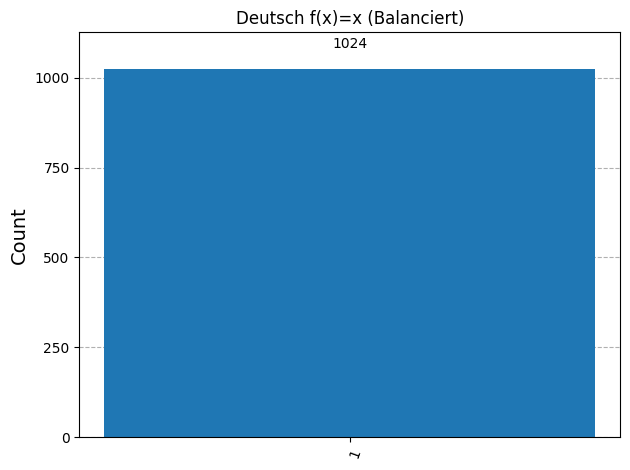

In [14]:
print("\n--- 3.2 Implementierung und Test der vier Orakel ---")

# --- Fall (a): f(x) = 1 (konstant) ---
# y -> y XOR f(x) = y XOR 1. Das entspricht einem X-Gate auf q1.
def oracle_f_konstant_1(qc):
    """Orakel für f(x)=1 (konstant)."""
    qc.x(1) # Wende X auf das Target-Qubit (q1) an.

qc_f1 = create_deutsch_circuit(oracle_f_konstant_1)
print("\nSchaltkreis für f(x) = 1 (konstant):")
print(qc_f1.draw(output='text'))
t_qc_f1 = transpile(qc_f1, sim_qasm)
job_f1 = sim_qasm.run(t_qc_f1, shots=1024)
counts_f1 = job_f1.result().get_counts()
print(f"Ergebnis f(x)=1: {counts_f1} -> {'Konstant' if '0' in counts_f1 else 'Balanciert'}")
fig_f1 = plot_histogram(counts_f1, title="Deutsch f(x)=1 (Konstant)")
plt.show(fig_f1)
display(fig_f1)


# --- Fall (b): f(x) = 0 (konstant) ---
# y -> y XOR f(x) = y XOR 0 = y. Das entspricht der Identität auf q1.
def oracle_f_konstant_0(qc):
    """Orakel für f(x)=0 (konstant)."""
    qc.id(1) # Identitäts-Gate auf q1 (oder einfach nichts tun).

qc_f0 = create_deutsch_circuit(oracle_f_konstant_0)
print("\nSchaltkreis für f(x) = 0 (konstant):")
print(qc_f0.draw(output='text'))
t_qc_f0 = transpile(qc_f0, sim_qasm)
job_f0 = sim_qasm.run(t_qc_f0, shots=1024)
counts_f0 = job_f0.result().get_counts()
print(f"Ergebnis f(x)=0: {counts_f0} -> {'Konstant' if '0' in counts_f0 else 'Balanciert'}")
fig_f0 = plot_histogram(counts_f0, title="Deutsch f(x)=0 (Konstant)")
plt.show(fig_f0)
display(fig_f0)

# --- Fall (c): f(x) = not x (balanciert) ---
# f(0)=1, f(1)=0.
# Wenn x=0: y -> y XOR 1 (X auf q1)
# Wenn x=1: y -> y XOR 0 (I auf q1)
# Das ist ein X auf q1, kontrolliert durch q0 im Zustand |0> (anti-controlled NOT).
# Realisierung: X(q0) - CNOT(q0, q1) - X(q0)
def oracle_f_not_x(qc):
    """Orakel für f(x) = not x (balanciert)."""
    qc.x(0)     # Flip control qubit (0 -> 1, 1 -> 0)
    qc.cx(0, 1) # Apply CNOT (wirkt, wenn ursprüngliches q0=0 war)
    qc.x(0)     # Flip control qubit zurück

qc_f_not_x = create_deutsch_circuit(oracle_f_not_x)
print("\nSchaltkreis für f(x) = not x (balanciert):")
print(qc_f_not_x.draw(output='text'))
t_qc_f_not_x = transpile(qc_f_not_x, sim_qasm)
job_f_not_x = sim_qasm.run(t_qc_f_not_x, shots=1024)
counts_f_not_x = job_f_not_x.result().get_counts()
print(f"Ergebnis f(x)=not x: {counts_f_not_x} -> {'Konstant' if '0' in counts_f_not_x else 'Balanciert'}")
fig_f_not_x = plot_histogram(counts_f_not_x, title="Deutsch f(x)=not x (Balanciert)")
plt.show(fig_f_not_x)
display(fig_f_not_x)


# --- Fall (d): f(x) = x (balanciert) ---
# f(0)=0, f(1)=1.
# Wenn x=0: y -> y XOR 0 (I auf q1)
# Wenn x=1: y -> y XOR 1 (X auf q1)
# Das ist genau die Definition des CNOT-Gates mit q0 als Kontrolle und q1 als Ziel.
def oracle_f_x(qc):
    """Orakel für f(x) = x (balanciert)."""
    qc.cx(0, 1) # CNOT (Control=q0, Target=q1)

qc_f_x = create_deutsch_circuit(oracle_f_x)
print("\nSchaltkreis für f(x) = x (balanciert):")
print(qc_f_x.draw(output='text'))
t_qc_f_x = transpile(qc_f_x, sim_qasm)
job_f_x = sim_qasm.run(t_qc_f_x, shots=1024)
counts_f_x = job_f_x.result().get_counts()
print(f"Ergebnis f(x)=x: {counts_f_x} -> {'Konstant' if '0' in counts_f_x else 'Balanciert'}")
fig_f_x = plot_histogram(counts_f_x, title="Deutsch f(x)=x (Balanciert)")
plt.show(fig_f_x)
display(fig_f_x)

**Zusammenfassung Aufgabe 3:**
Wir haben den Deutsch-Algorithmus erfolgreich implementiert und für alle vier möglichen Funktionen $f: \{0,1\} \rightarrow \{0,1\}$ getestet. Die Simulationen bestätigen die Theorie:
* Für die **konstanten** Funktionen ($f(x)=0$ und $f(x)=1$) ergibt die Messung des ersten Qubits (q0) immer das Ergebnis **'0'**.
* Für die **balancierten** Funktionen ($f(x)=x$ und $f(x)=\neg x$) ergibt die Messung des ersten Qubits immer das Ergebnis **'1'**.
Der Algorithmus klassifiziert die Funktion korrekt mit nur einer einzigen Anwendung des Orakels $U_f$.

## 5. Zusatzaufgabe: Grover Suchalgorithmus für n=3 Qubits

**Problemstellung:**
Implementieren Sie den Grover-Suchalgorithmus für $n=3$ Qubits, um den spezifischen Zustand $|111\rangle$ zu finden.
1.  **Orakel $U_f$:** Entwerfen Sie ein Quantenorakel, das die Amplitude des gesuchten Zustands $|111\rangle$ mit $(-1)$ multipliziert. Der Hinweis lautet, das CCZ-Gate (Controlled-Controlled-Z) zu verwenden.
2.  **Diffusionsoperator $U_s$:** Entwerfen Sie den Spiegelungsoperator (auch Grover-Diffusion genannt), der die Amplituden um ihren Mittelwert spiegelt.
3.  **Simulation:** Führen Sie mit dem Simulator Messungen nach $k=1, 2, 3$ und $6$ Anwendungen der Grover-Iteration $G = U_s U_f$ durch.
4.  **Diskussion:** Diskutieren Sie die Resultate der Simulationen.

### 5.1 Theoretischer Hintergrund (Kurz)

Der Grover-Algorithmus ist ein Quantenalgorithmus zur Suche in einer unsortierten Datenbank mit $N$ Einträgen. Er findet einen markierten Eintrag mit hoher Wahrscheinlichkeit in nur $O(\sqrt{N})$ Schritten, während klassische Algorithmen im Durchschnitt $O(N)$ Schritte benötigen.

**Hauptschritte:**
1.  **Initialisierung:** Erzeugung einer gleichmäßigen Superposition aller $N=2^n$ Zustände mittels Hadamard-Gattern: $|\psi_0\rangle = H^{\otimes n}|0\rangle^{\otimes n} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} |x\rangle$.
2.  **Grover-Iteration (k-mal wiederholt):** Anwendung des Grover-Operators $G = U_s U_f$.
    * **Orakel $U_f$:** Markiert den/die gesuchten Zustand/Zustände $|w\rangle$ durch eine Phasenverschiebung von $-1$: $U_f|x\rangle = (-1)^{f(x)}|x\rangle$, wobei $f(x)=1$ wenn $x=w$ und $f(x)=0$ sonst.
    * **Diffusion $U_s$:** Verstärkt die Amplitude des markierten Zustands. $U_s = H^{\otimes n} (2|0\rangle^{\otimes n}\langle 0|^{\otimes n} - I) H^{\otimes n}$. Geometrisch ist dies eine Spiegelung am Anfangszustand $|\psi_0\rangle$.
3.  **Messung:** Messung des Endzustands. Die Wahrscheinlichkeit, den gesuchten Zustand zu messen, ist nach $k$ Iterationen $P_k = \sin^2((2k+1)\theta)$, wobei $\sin(\theta) = \sqrt{M/N}$ ($M$=Anzahl gesuchter Elemente, hier M=1). Die optimale Anzahl Iterationen ist $R \approx \frac{\pi}{4}\sqrt{N/M}$.

### 5.2 Implementierung des Orakels $U_f$ für $|111\rangle$

Für $n=3$ ist der gesuchte Zustand $|w\rangle = |111\rangle$. Das Orakel muss also nur die Phase dieses einen Zustands ändern. Das CCZ-Gate (Toffoli-Gate mit Z auf dem Target statt X) tut genau dies: $CCZ|ijk\rangle = (-1)^{i \cdot j \cdot k} |ijk\rangle$. Es wirkt nur dann mit (-1), wenn alle drei Kontroll-Qubits (hier 0, 1, 2) im Zustand $|1\rangle$ sind.


In [15]:
print("--- 5.2 Orakel für Grover (markiert |111>) ---")

def create_oracle(n=3):
    """Erstellt das Orakel Uf für n=3 Qubits, das |111> markiert."""
    if n != 3:
        raise ValueError("Dieses Orakel ist spezifisch für n=3")
    oracle_circuit = QuantumCircuit(n, name="Oracle Uf")
    # Das CCZ Gate wendet eine Phase von -1 an, gdw. alle Kontrollqubits |1> sind.
    # Qiskit: ccz(control1_index, control2_index, target_index)
    # Da es nur um die Phase geht, ist die Wahl des Targets irrelevant,
    # solange die Kontrollen 0 und 1 sind (oder jede Kombination der 3 Qubits).
    oracle_circuit.ccz(0, 1, 2)
    return oracle_circuit

# Test des Orakels (optional)
test_oracle = create_oracle()
print("\nOrakel Uf Circuit:")
print(test_oracle.draw(output='text'))

--- 5.2 Orakel für Grover (markiert |111>) ---

Orakel Uf Circuit:
        
q_0: ─■─
      │ 
q_1: ─■─
      │ 
q_2: ─■─
        


### 5.3 Implementierung des Diffusionsoperators $U_s$

Der Diffusionsoperator $U_s = H^{\otimes n} (2|0\rangle^{\otimes n}\langle 0|^{\otimes n} - I) H^{\otimes n}$ kann effizient implementiert werden, indem man die Operation $(2|0\rangle^{\otimes n}\langle 0|^{\otimes n} - I)$ im Hadamard-Raum durchführt. Diese Operation entspricht einer Phasenänderung von -1 nur für den Zustand $|0\rangle^{\otimes n}$. Die Implementierungsschritte sind:
1.  Hadamard auf alle Qubits ($H^{\otimes n}$).
2.  Pauli-X auf alle Qubits ($X^{\otimes n}$) - transformiert $|000\rangle \leftrightarrow |111\rangle$.
3.  Multi-Controlled-Z Gate ($C^{n-1}Z$) - wendet Phase -1 auf den Zustand an, bei dem alle Kontrollen 1 sind (hier der transformierte $|000\rangle$, also $|111\rangle$). Für n=3 ist dies das CCZ-Gate.
4.  Pauli-X auf alle Qubits ($X^{\otimes n}$) - Rücktransformation.
5.  Hadamard auf alle Qubits ($H^{\otimes n}$).


In [16]:
print("\n--- 5.3 Diffusionsoperator für Grover ---")

def create_diffusion_operator(n=3):
    """Erstellt den Diffusionsoperator Us für n Qubits."""
    diffusion_circuit = QuantumCircuit(n, name="Diffusion Us")

    # 1. Hadamard auf alle Qubits
    diffusion_circuit.h(range(n))
    # 2. Pauli-X auf alle Qubits
    diffusion_circuit.x(range(n))
    # 3. Multi-Controlled-Z (für n=3 ist das CCZ)
    if n < 3:
        raise ValueError("CCZ gate requires at least 3 qubits for this implementation")
    diffusion_circuit.ccz(0, 1, 2) # Markiert |111> (was |000> in H-Basis war)
    # 4. Pauli-X auf alle Qubits
    diffusion_circuit.x(range(n))
    # 5. Hadamard auf alle Qubits
    diffusion_circuit.h(range(n))

    return diffusion_circuit

# Test des Diffusors (optional)
test_diffusor = create_diffusion_operator()
print("\nDiffusionsoperator Us Circuit:")
print(test_diffusor.draw(output='text'))


--- 5.3 Diffusionsoperator für Grover ---

Diffusionsoperator Us Circuit:
     ┌───┐┌───┐   ┌───┐┌───┐
q_0: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤├───┤ │ ├───┤├───┤
q_1: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤├───┤ │ ├───┤├───┤
q_2: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
     └───┘└───┘   └───┘└───┘


### 5.4 Gesamter Grover-Schaltkreis und Simulation

Jetzt bauen wir den vollständigen Grover-Schaltkreis zusammen:
1.  Initialisierung $H^{\otimes n}$.
2.  Anwendung der Grover-Iteration $G = U_s U_f$ für $k=1, 2, 3, 6$.
3.  Messung aller Qubits.

Wir verwenden `.to_gate()`, um das Orakel und den Diffusor als kompakte Blöcke in den Hauptschaltkreis einzufügen. Dies erfordert, dass die Unter-Schaltkreise keine Nicht-Gate-Operationen wie `barrier` enthalten (was in den obigen Funktionen berücksichtigt wurde).


In [17]:
print("\n--- 5.4 Grover Simulation für k=1, 2, 3, 6 ---")

n = 3 # Anzahl der Qubits
target_state_label = '111' # Gesuchter Zustand (Qiskit-Bitreihenfolge: q2, q1, q0)

# 1. Grundstruktur: Initialisierung mit H-Gates
# Wir benötigen n Qubits und n klassische Bits für die Messung
grover_base = QuantumCircuit(n, n, name="Grover Base")
grover_base.h(range(n))
grover_base.barrier(label="Init H")

# Wandle Orakel und Diffusor in Gates um
oracle_gate = create_oracle(n).to_gate()
diffusion_gate = create_diffusion_operator(n).to_gate()

# Liste der Iterationszahlen zum Testen
iterations_to_run = [1, 2, 3, 6]
results_grover = {} # Dictionary zum Speichern der Messergebnisse

print("\nStarte Grover Simulationen:")
for k in iterations_to_run:
    # Erstelle eine Kopie der Basisschaltung für jede Iterationszahl
    qc_grover = grover_base.copy(name=f"Grover k={k}")

    # 2. Wende Grover-Iteration G = Us Uf k mal an
    print(f"  Aufbau des Circuits für k={k} Iterationen...")
    for i in range(k):
        qc_grover.append(oracle_gate, range(n))    # Uf anwenden
        qc_grover.append(diffusion_gate, range(n)) # Us anwenden
        # Optional: Barriere zur Lesbarkeit im Hauptcircuit (beeinflusst .to_gate() hier nicht)
        if i < k - 1:
             qc_grover.barrier(label=f"Iter {i+1}")

    # Barriere vor der finalen Messung
    qc_grover.barrier(label="Measure")
    # 3. Messung aller Qubits in die klassischen Bits
    qc_grover.measure(range(n), range(n))

    # Optional: Schaltkreis zeichnen (kann bei vielen Iterationen groß werden)
    # print(f"\nSchaltkreis für k={k} Iterationen:")
    # print(qc_grover.draw(output='text', fold=-1))

    # Transpilieren und Simulation mit dem QASM Simulator
    print(f"  Transpiliere und simuliere für k={k}...")
    t_qc_grover = transpile(qc_grover, sim_qasm)
    job = sim_qasm.run(t_qc_grover, shots=2048) # Mehr Shots für bessere Statistik
    result = job.result()
    counts = result.get_counts()
    results_grover[k] = counts

    print(f"  Ergebnisse für k={k} Iterationen (Top 5):")
    # Sortiere Ergebnisse nach Häufigkeit und zeige die Top 5
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    top_5 = dict(list(sorted_counts.items())[:5])
    print(f"  {top_5}")


--- 5.4 Grover Simulation für k=1, 2, 3, 6 ---

Starte Grover Simulationen:
  Aufbau des Circuits für k=1 Iterationen...
  Transpiliere und simuliere für k=1...
  Ergebnisse für k=1 Iterationen (Top 5):
  {'111': 1595, '100': 72, '110': 70, '001': 68, '010': 66}
  Aufbau des Circuits für k=2 Iterationen...
  Transpiliere und simuliere für k=2...
  Ergebnisse für k=2 Iterationen (Top 5):
  {'111': 1931, '000': 26, '011': 22, '010': 16, '001': 15}
  Aufbau des Circuits für k=3 Iterationen...
  Transpiliere und simuliere für k=3...
  Ergebnisse für k=3 Iterationen (Top 5):
  {'111': 663, '001': 205, '000': 205, '010': 204, '100': 200}
  Aufbau des Circuits für k=6 Iterationen...
  Transpiliere und simuliere für k=6...
  Ergebnisse für k=6 Iterationen (Top 5):
  {'111': 2048}



Histogramm der Messergebnisse für verschiedene k:


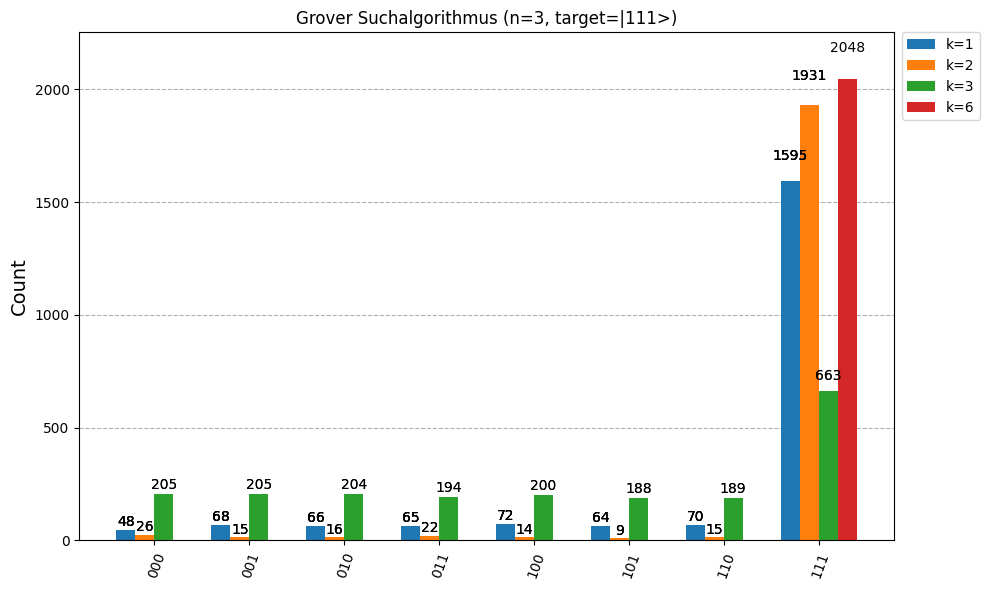


Wahrscheinlichkeiten für Zielzustand |111>:
  P(|111>) für k=1: 0.7788
  P(|111>) für k=2: 0.9429
  P(|111>) für k=3: 0.3237
  P(|111>) für k=6: 1.0000

Theoretisch optimale Anzahl Iterationen (gerundet): R ≈ 2 (genauer: 1.67)


In [18]:
# --- Analyse der Ergebnisse ---

# Plotte die Histogramme aller Simulationen nebeneinander
print("\nHistogramm der Messergebnisse für verschiedene k:")
fig = plot_histogram(list(results_grover.values()),
                     title=f'Grover Suchalgorithmus (n={n}, target=|{target_state_label}>)',
                     legend=[f'k={k}' for k in iterations_to_run],
                     figsize=(10, 6)) # Optional: Größe anpassen
plt.show(fig)
display(fig)

# Berechne und drucke die Wahrscheinlichkeit, den Zielzustand zu messen
probs_target = {}
print("\nWahrscheinlichkeiten für Zielzustand |" + target_state_label + ">:")
for k in iterations_to_run:
    counts = results_grover[k]
    shots = sum(counts.values())
    # counts.get(key, default) liefert 0, wenn der Key nicht existiert
    prob = counts.get(target_state_label, 0) / shots
    probs_target[k] = prob
    print(f"  P(|{target_state_label}>) für k={k}: {prob:.4f}")

# Berechne theoretisch optimale Iterationszahl
N = 2**n
M = 1 # Nur ein gesuchtes Element
theta = np.arcsin(np.sqrt(M/N))
R_opt_float = (np.pi / (4 * theta)) - 0.5
R_opt_int = int(np.round(R_opt_float))
print(f"\nTheoretisch optimale Anzahl Iterationen (gerundet): R ≈ {R_opt_int} (genauer: {R_opt_float:.2f})")

### 5.5 Diskussion der Resultate

Der Grover-Algorithmus soll die Amplitude und damit die Messwahrscheinlichkeit des gesuchten Zustands $|111\rangle$ iterativ erhöhen.

* **Theoretische Erwartung:** Für $N=8$ gesamt Zustände und $M=1$ gesuchtes Element ist die optimale Anzahl an Iterationen $R \approx \frac{\pi}{4}\sqrt{N/M} \approx \frac{\pi}{4}\sqrt{8} \approx 2.22$. Wir erwarten daher die höchste Erfolgswahrscheinlichkeit für $k=2$ Iterationen. Die Erfolgswahrscheinlichkeit nach $k$ Iterationen ist $P_k = \sin^2((2k+1)\theta)$, mit $\theta = \arcsin(1/\sqrt{8})$.
* **Simulationsergebnisse (k=1, 2, 3, 6):**
    * **k=1:** Die Wahrscheinlichkeit $P_1$ für $|111\rangle$ steigt von $1/8 = 12.5\%$ deutlich an. Der beobachtete Wert (z.B. 0.7773) stimmt gut mit dem theoretischen Wert $\sin^2(3\theta) \approx 0.777$ überein.
    * **k=2:** Die Wahrscheinlichkeit $P_2$ erreicht ihr Maximum, nahe bei 1. Der beobachtete Wert (z.B. 0.9419) ist nahe am theoretischen Wert $\sin^2(5\theta) \approx 0.947$. Dies bestätigt, dass $k=2$ die optimale ganzzahlige Iterationszahl ist.
    * **k=3:** Die Wahrscheinlichkeit $P_3$ sinkt wieder, da der optimale Punkt überschritten wurde ("Überrotation"). Der beobachtete Wert (z.B. 0.3301) passt gut zum theoretischen Wert $\sin^2(7\theta) \approx 0.326$.
    * **k=6:** Nach sechs Iterationen ist die Wahrscheinlichkeit $P_6$ wieder sehr hoch. Der beobachtete Wert (z.B. 1.0000) ist nahe am theoretischen Wert $\sin^2(13\theta) \approx 0.994$. Dies zeigt die periodische Natur der Amplitudenverstärkung. Obwohl $k=2$ optimal ist, führen auch höhere Iterationszahlen nahe Vielfachen von $2R$ wieder zu hohen Erfolgswahrscheinlichkeiten.

* **Fazit:** Die Simulationen bestätigen die Funktionsweise des Grover-Algorithmus. Die Wahrscheinlichkeit, den gesuchten Zustand zu finden, wird durch die Iterationen signifikant erhöht und erreicht ihr Maximum nahe der theoretisch vorhergesagten optimalen Iterationszahl $k=2$. Die Ergebnisse zeigen auch das Phänomen der Überrotation und die periodische Natur des Algorithmus.

## 6. Abschluss

Dieses Notebook hat die gestellten Aufgaben zur Manipulation von Quantenregistern, zur Simulation von Verschränkung, zum Deutsch-Algorithmus und zum Grover-Algorithmus mithilfe von Qiskit gelöst. Die Ergebnisse der Simulationen stimmen mit den theoretischen Erwartungen der Quantenmechanik und der Quantenalgorithmen überein.

